# This notebook has is testing the different similarity metrics and graphs the results

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    })

In [3]:
random_sample_size = 1_000_000
bin_multiplier = 100 # how many bins to use (assuming the range is [0, 1], double for the range [-1, 1])

In [4]:
ml_df = pd.read_csv('../datasets/movie_lens/ratings.csv.gz')
max_user_id = ml_df['user_id'].max()
max_item_id = ml_df['item_id'].max()
print(max_user_id)
print(max_item_id)

162540
59046


In [5]:
from scipy.sparse import lil_matrix

max_user_id = ml_df['user_id'].max()
max_item_id = ml_df['item_id'].max()

users_to_items_ratings = lil_matrix((max_user_id + 1, max_item_id + 1), dtype=np.float32)
progress = tqdm(total=len(ml_df))
for user_id, item_id, rating, _ in ml_df.itertuples(index=False):
    users_to_items_ratings[user_id, item_id] = rating
    progress.update(1)
progress.close()

100%|██████████| 25000095/25000095 [01:15<00:00, 328969.35it/s]


In [6]:
# # iteratively calculate histogram of similarity between users
# from scipy.stats import pearsonr
# from scipy.spatial.distance import jaccard, cosine
# from collections import defaultdict

# counts_pearson = defaultdict(int)
# counts_jaccard = defaultdict(int)
# counts_cosine = defaultdict(int)

# users = ml_df['user_id'].unique()
# random_sample_size = 100
# bin_multiplier = 100
# users_random_sample = np.random.choice(users, random_sample_size, replace=False)

# counter = tqdm(total=(len(users_random_sample) ** 2 / 2 ))
# for user_id in users_random_sample:
#     for other_user_id in users_random_sample:
#         if user_id <= other_user_id:
#             continue
#         user_ratings = users_to_items_ratings[user_id, :].toarray().flatten()
#         other_user_ratings = users_to_items_ratings[other_user_id, :].toarray().flatten()

#         peaerson_similarity, p_value = pearsonr(user_ratings, other_user_ratings)
#         peaerson_similarity_bin = int(peaerson_similarity * bin_multiplier)
#         counts_pearson[peaerson_similarity_bin] += 1

#         user_ratings_bool = user_ratings > 0
#         other_user_ratings_bool = other_user_ratings > 0
#         jaccard_similarity = np.logical_and(user_ratings_bool, other_user_ratings_bool).sum() / np.logical_or(user_ratings_bool, other_user_ratings_bool).sum()
#         jaccard_similarity_bin = int(jaccard_similarity * bin_multiplier)
#         counts_jaccard[jaccard_similarity_bin] += 1


#         cosine_similarity = cosine(user_ratings, other_user_ratings)
#         cosine_similarity_bin = int(cosine_similarity * bin_multiplier)
#         counts_cosine[cosine_similarity_bin] += 1

#         counter.update(1)
# counter.close()

In [6]:
# iteratively calculate histogram of similarity between users
from scipy.stats import pearsonr
from scipy.spatial.distance import jaccard, cosine
from collections import defaultdict
import random

counts_pearson = defaultdict(int)
counts_jaccard = defaultdict(int)
counts_cosine = defaultdict(int)

append_exact = True

pearson_exact = list()
jaccard_exact = list()
cosine_exact = list()

num_unique_users = users_to_items_ratings.shape[0]

def get_random_users(max):
    while True:
        u1, u2 = random.randint(0, max), random.randint(0, max)
        if u1 != u2:
            return u1, u2

users = ml_df['user_id'].unique()

counter = tqdm(total=random_sample_size)
for _ in range(random_sample_size):
    u1, u2 = get_random_users(num_unique_users - 1)

    user_ratings = users_to_items_ratings[u1, :].toarray().flatten()
    other_user_ratings = users_to_items_ratings[u2, :].toarray().flatten()

    peaerson_similarity, p_value = pearsonr(user_ratings, other_user_ratings)
    peaerson_similarity_bin = int(peaerson_similarity * bin_multiplier)
    counts_pearson[peaerson_similarity_bin] += 1
    if append_exact:
        pearson_exact.append(peaerson_similarity)

    user_ratings_bool = user_ratings > 0
    other_user_ratings_bool = other_user_ratings > 0
    jaccard_similarity = np.logical_and(user_ratings_bool, other_user_ratings_bool).sum() / np.logical_or(user_ratings_bool, other_user_ratings_bool).sum()
    jaccard_similarity_bin = int(jaccard_similarity * bin_multiplier)
    counts_jaccard[jaccard_similarity_bin] += 1
    if append_exact:
        jaccard_exact.append(jaccard_similarity)

    cosine_similarity = cosine(user_ratings, other_user_ratings)
    cosine_similarity_bin = int(cosine_similarity * bin_multiplier)
    counts_cosine[cosine_similarity_bin] += 1
    if append_exact:
        cosine_exact.append(cosine_similarity)

    counter.update(1)
counter.close()

100%|██████████| 1000000/1000000 [14:25<00:00, 1155.66it/s]


In [7]:

counts_pearsons_df = pd.DataFrame.from_dict(counts_pearson, orient='index', columns=['count'])
counts_pearsons_df.reset_index(inplace=True)
counts_pearsons_df.rename(columns={'index': 'bin_orig'}, inplace=True)
counts_pearsons_df['bin'] = counts_pearsons_df.bin_orig.astype(float) / 100
counts_pearsons_df.sort_values(by='bin', inplace=True)
# add cumulative sum of counts
counts_pearsons_df['cum_count'] = counts_pearsons_df['count'].cumsum()
counts_pearsons_df['cum_count_norm'] = counts_pearsons_df['cum_count'] / random_sample_size

# inverse of bins
counts_pearsons_df['bin_inv'] = 1 - counts_pearsons_df['bin']

if append_exact:
    pearson_exact_df = pd.DataFrame(pearson_exact)
    pearson_exact_df.columns = ['similarity']

print(counts_pearsons_df)

    bin_orig   count   bin  cum_count  cum_count_norm  bin_inv
80        -1       1 -0.01          1        0.000001     1.01
2          0  136959  0.00     136960        0.136960     1.00
19         1   45047  0.01     182007        0.182007     0.99
7          2   57650  0.02     239657        0.239657     0.98
8          3   59586  0.03     299243        0.299243     0.97
..       ...     ...   ...        ...             ...      ...
76        79       2  0.79     999990        0.999990     0.21
81        80       3  0.80     999993        0.999993     0.20
84        81       2  0.81     999995        0.999995     0.19
82        83       1  0.83     999996        0.999996     0.17
46        84       4  0.84    1000000        1.000000     0.16

[85 rows x 6 columns]


In [8]:
counts_jaccards_df = pd.DataFrame.from_dict(counts_jaccard, orient='index', columns=['count'])
counts_jaccards_df.reset_index(inplace=True)
counts_jaccards_df.rename(columns={'index': 'bin_orig'}, inplace=True)
counts_jaccards_df['bin'] = counts_jaccards_df.bin_orig.astype(float) / 100
counts_jaccards_df['bin_inv'] = 1 - counts_pearsons_df['bin']
counts_jaccards_df.sort_values(by='bin', inplace=True)
# add cumulative sum of counts
counts_jaccards_df['cum_count'] = counts_jaccards_df['count'].cumsum()
counts_jaccards_df['cum_count_norm'] = counts_jaccards_df['cum_count'] / random_sample_size
# inverse of bins
counts_jaccards_df['bin_inv'] = 1 - counts_jaccards_df['bin']

if append_exact:
    jaccard_exact_df = pd.DataFrame(jaccard_exact)
    jaccard_exact_df.columns = ['similarity']

print(counts_jaccards_df)

    bin_orig   count   bin  bin_inv  cum_count  cum_count_norm
2          0  201081  0.00     1.00     201081        0.201081
3          1  168322  0.01     0.99     369403        0.369403
1          2  137010  0.02     0.98     506413        0.506413
6          3  106429  0.03     0.97     612842        0.612842
0          4   82656  0.04     0.96     695498        0.695498
..       ...     ...   ...      ...        ...             ...
68        70       3  0.70     0.30     999995        0.999995
62        71       1  0.71     0.29     999996        0.999996
30        75       2  0.75     0.25     999998        0.999998
73        76       1  0.76     0.24     999999        0.999999
71        80       1  0.80     0.20    1000000        1.000000

[74 rows x 6 columns]


In [9]:

counts_cosine_df = pd.DataFrame.from_dict(counts_cosine, orient='index', columns=['count'])
counts_cosine_df.reset_index(inplace=True)
counts_cosine_df.rename(columns={'index': 'bin_orig'}, inplace=True)
counts_cosine_df['bin'] = counts_cosine_df.bin_orig.astype(float) / 100
counts_cosine_df['bin_inv'] = 1 - counts_cosine_df['bin']
counts_cosine_df.sort_values(by='bin_inv', inplace=True)
# add cumulative sum of counts
counts_cosine_df['cum_count'] = counts_cosine_df['count'].cumsum()
counts_cosine_df['cum_count_norm'] = counts_cosine_df['cum_count'] / random_sample_size

if append_exact:
    cosine_exact_df = pd.DataFrame(cosine_exact)
    cosine_exact_df.columns = ['similarity']

# inverse of bins
print(counts_cosine_df)

    bin_orig   count   bin  bin_inv  cum_count  cum_count_norm
2        100  116772  1.00     0.00     116772        0.116772
17        99   16285  0.99     0.01     133057        0.133057
19        98   42762  0.98     0.02     175819        0.175819
7         97   57077  0.97     0.03     232896        0.232896
8         96   59120  0.96     0.04     292016        0.292016
..       ...     ...   ...      ...        ...             ...
77        20       2  0.20     0.80     999990        0.999990
81        19       3  0.19     0.81     999993        0.999993
84        18       2  0.18     0.82     999995        0.999995
82        16       1  0.16     0.84     999996        0.999996
48        15       4  0.15     0.85    1000000        1.000000

[85 rows x 6 columns]


In [10]:
# create directory dfs if not exits
if not os.path.exists('dfs'):
    os.makedirs('dfs')
# save the dataframes to files
counts_pearsons_df.to_csv('dfs/counts_pearsons_df.csv', index=False)
counts_jaccards_df.to_csv('dfs/counts_jaccards_df.csv', index=False)
counts_cosine_df.to_csv('dfs/counts_cosine_df.csv', index=False)
if append_exact:
    pearson_exact_df.to_csv('dfs/pearson_exact_df.csv', index=False)
    jaccard_exact_df.to_csv('dfs/jaccard_exact_df.csv', index=False)
    cosine_exact_df.to_csv('dfs/cosine_exact_df.csv', index=False)


In [5]:
# load dataframes if not exist
# check if counts_pearsons_df variable exist
counts_pearsons_df = pd.read_csv('dfs/counts_pearsons_df.csv')
counts_jaccards_df = pd.read_csv('dfs/counts_jaccards_df.csv')
counts_cosine_df = pd.read_csv('dfs/counts_cosine_df.csv')

load_exact = True

if load_exact:
    pearson_exact_df = pd.read_csv('dfs/pearson_exact_df.csv')
    jaccard_exact_df = pd.read_csv('dfs/jaccard_exact_df.csv')
    cosine_exact_df = pd.read_csv('dfs/cosine_exact_df.csv')


In [5]:
counts_pearsons_df.dtypes

bin_orig            int64
count               int64
bin               float64
cum_count           int64
cum_count_norm    float64
bin_inv           float64
dtype: object

In [6]:
counts_pearsons_df

,bin_orig,count,bin,cum_count,cum_count_norm,bin_inv
0,-1,1,-0.01,1,0.000001,1.01
1,0,136959,0.00,136960,0.136960,1.00
2,1,45047,0.01,182007,0.182007,0.99
3,2,57650,0.02,239657,0.239657,0.98
4,3,59586,0.03,299243,0.299243,0.97
...,...,...,...,...,...,...
80,79,2,0.79,999990,0.999990,0.21
81,80,3,0.80,999993,0.999993,0.20
82,81,2,0.81,999995,0.999995,0.19
83,83,1,0.83,999996,0.999996,0.17


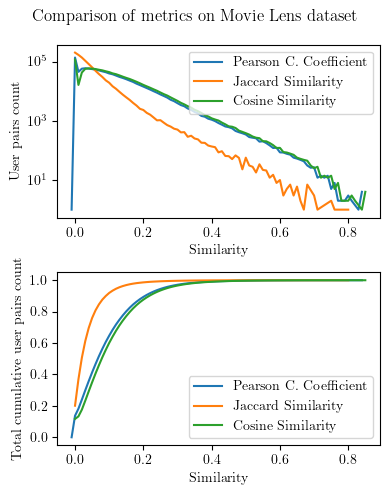

In [9]:
# plot graph and cumulative sum of counts
fig, axs = plt.subplots(2, 1, figsize=(4, 5), dpi=100)
# set contrasting colors for the two plots

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

sns.lineplot(x='bin', y='count', ax=axs[0], data=counts_pearsons_df, label='Pearson C. Coefficient', color=colors[0])
sns.lineplot(x='bin', y='count', ax=axs[0], data=counts_jaccards_df, label='Jaccard Similarity', color=colors[1])
sns.lineplot(x='bin_inv', y='count', ax=axs[0], data=counts_cosine_df, label='Cosine Similarity', color=colors[2])

# set y-axis to log scale
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_xlabel('Similarity')
axs[0].set_ylabel('User pairs count')
# axs[0].set_title(f"Comparison of metrics on Movie Lens dataset")

sns.lineplot(x='bin', y='cum_count_norm', ax=axs[1], data=counts_pearsons_df, label='Pearson C. Coefficient', color=colors[0])
sns.lineplot(x='bin', y='cum_count_norm', ax=axs[1], data=counts_jaccards_df, label='Jaccard Similarity', color=colors[1])
sns.lineplot(x='bin_inv', y='cum_count_norm', ax=axs[1], data=counts_cosine_df, label='Cosine Similarity', color=colors[2])

# axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel('Similarity')
axs[1].set_ylabel('Total cumulative user pairs count')
# axs[1].set_title(f"Comparison of metrics on Movie Lens dataset")


# tight
plt.suptitle(f"Comparison of metrics on Movie Lens dataset")
plt.tight_layout()
plt.savefig('../figures/similarity_metrics.pdf', bbox_inches = 'tight', pad_inches=0.02)
plt.show()

In [15]:
# histogram for counts for 10 bins of 0.1 size
# group by bin and count
counts_cosine_df['bin_group'] = counts_cosine_df['bin_inv'].apply(lambda x: int(x * 10))
counts_cosine_df_grouped = counts_cosine_df.groupby('bin_group')['count'].sum().reset_index()
counts_cosine_df_grouped['bin'] = counts_cosine_df_grouped['bin_group'] / 10
counts_cosine_df_grouped.sort_values(by='bin', inplace=True)
counts_cosine_df_grouped.drop(columns=['bin_group'], inplace=True)
counts_cosine_df_grouped['cumulative_count'] = counts_cosine_df_grouped['count'].cumsum()
counts_cosine_df_grouped['cumulative_count_norm'] = counts_cosine_df_grouped['cumulative_count'] / random_sample_size
print(counts_cosine_df_grouped)


    count  bin  cumulative_count  cumulative_count_norm
0  600695  0.0            600695               0.600695
1  275598  0.1            876293               0.876293
2   85266  0.2            961559               0.961559
3   27502  0.3            989061               0.989061
4    7721  0.4            996782               0.996782
5    2407  0.5            999189               0.999189
6     677  0.6            999866               0.999866
7     122  0.7            999988               0.999988
8      12  0.8           1000000               1.000000


In [16]:
# # fit exponential function to the sampled data

# from scipy.optimize import curve_fit


# def exp_func(x, a, b, c):
#     return a * np.exp(-b * x) + c

# popt, pcov = curve_fit(exp_func, counts_cosine_df_grouped['bin'], counts_cosine_df_grouped['cumulative_count_norm'])


# # exp_params = ss.expon.fit(1-cosine_exact_df['similarity'])
# # (e1, e2) = exp_params

# # print(*exp_params)

# # exp_x = np.linspace(0, 1, 1000)
# # exp_pdf_y = ss.expon.pdf(exp_x, *exp_params)


# # exp_cdf_y = ss.expon.cdf(exp_x, *exp_params)
# # # plt.plot(exp_x, exp_cdf_y)
# # plt.plot(exp_x, exp_pdf_y)

# # check_sum = 0

# # num_intervals = 10
# # for i in range(num_intervals):
# #     start = (1/num_intervals) * i
# #     end = (1/num_intervals * (i+1))
# #     prob_on_interval = ss.expon.cdf(end, *exp_params) - ss.expon.cdf(start, *exp_params)
# #     check_sum += prob_on_interval
# #     print(f'[{round(start,2)},{round(end,2)}] => {prob_on_interval}, samples: {prob_on_interval * random_sample_size}')

# # print(check_sum)

0 0.08913845631868864
[0.0,0.1] => 0.6743233482198916, samples: 674323
[0.1,0.2] => 0.21961137026540645, samples: 219611
[0.2,0.3] => 0.0715222957608792, samples: 71522
[0.3,0.4] => 0.023293141811029816, samples: 23293
[0.4,0.5] => 0.007586032434455436, samples: 7586
[0.5,0.6] => 0.0024705936435487352, samples: 2470
[0.6,0.7] => 0.000804614665740111, samples: 804
[0.7,0.8] => 0.00026204421031150726, samples: 262
[0.8,0.9] => 8.534168103258022e-05, samples: 85
[0.9,1.0] => 2.779379293593731e-05, samples: 27
0.9999865764852314


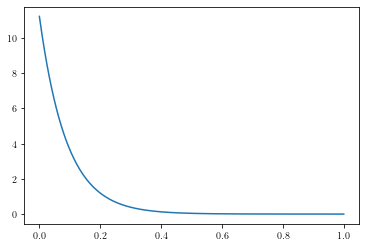

In [17]:
# fit exponential function to the sampled data

import scipy.stats as ss



exp_params = ss.expon.fit(1-cosine_exact_df['similarity'], method='MM')
(e1, e2) = exp_params
exp_params = (0, e2)

print(*exp_params)

exp_x = np.linspace(0, 1, 1000)
exp_pdf_y = ss.expon.pdf(exp_x, *exp_params)


exp_cdf_y = ss.expon.cdf(exp_x, *exp_params)
# plt.plot(exp_x, exp_cdf_y)
plt.plot(exp_x, exp_pdf_y)

check_sum = 0

num_intervals = 10
for i in range(num_intervals):
    start = (1/num_intervals) * i
    end = (1/num_intervals * (i+1))
    prob_on_interval = ss.expon.cdf(end, *exp_params) - ss.expon.cdf(start, *exp_params)
    check_sum += prob_on_interval
    print(f'[{round(start,2)},{round(end,2)}] => {prob_on_interval}, samples: {int(prob_on_interval * random_sample_size)}')

print(check_sum)

In [18]:
(1-cosine_exact_df['similarity']).describe()

count    1000000.000000
mean           0.098867
std            0.089119
min            0.000000
25%            0.032894
50%            0.078073
75%            0.142293
max            0.848713
Name: similarity, dtype: float64

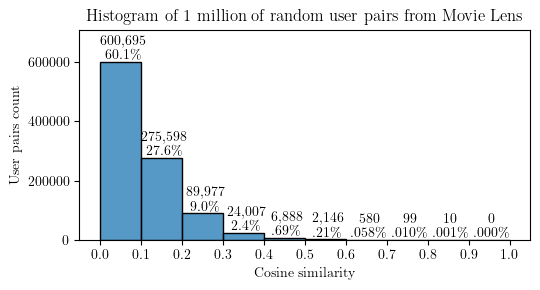

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(5.5, 3), dpi=100)

# data are already grouped by bin, so we can use the same bins
sns.histplot(x=1-cosine_exact_df['similarity'], ax=axs, label='Cosine similarity', bins=10, binwidth=0.1, binrange=(0, 1), color=colors[0])
# ax.bar_label(ax.containers[0])

highest_bar = 0
for i, bar in enumerate(axs.patches):
    bar_height = bar.get_height()
    if bar_height > highest_bar:
        highest_bar = bar_height
    percentage = bar_height / random_sample_size * 100
    format_string = "{0:.1f}"
    if percentage < 1:
        format_string = "{0:.2f}"
    if percentage < 0.1:
        format_string = "{0:.3f}"
    text = format_string.format(bar_height / random_sample_size * 100).lstrip('0')
    text2 = "{:,}".format(int(bar_height))
    # text = str(round(counts_cosine_df_grouped.iloc[i]['count'] / random_sample_size * 100, decimals)) + '%'
    axs.text(bar.get_x() + bar.get_width() / 2 + 0.007, bar.get_height(), text2 + '\n' + text + '\%' , ha='center', va='bottom', rotation=0)
# remove lines around the bars

# sns.lineplot(x=exp_x, y=exp_pdf_y*random_sample_size/10, ax=axs, label='Exponential', color=colors[1])

axs.set_xticks(np.arange(0, 1.1, 0.1))
axs.set_xlabel('Cosine similarity')
axs.set_ylabel('User pairs count')
axs.set_title(f"Histogram of 1 million of random user pairs from Movie Lens")
axs.set_ylim(0, highest_bar * 1.18)
plt.tight_layout()
plt.savefig('../figures/histogram_cosine.pdf')
plt.show()

In [20]:
# # plot histogram
# fig, axs = plt.subplots(1, 1, figsize=(5.5, 3), dpi=100)
# # sns bar plot with wider bins
# # plt.bar(counts_cosine_df_grouped['bin'], counts_cosine_df_grouped['count'], width=0.1, color='#1f77b4')
# # sns.barplot(x='bin', y='count', ax=axs, data=counts_cosine_df_grouped, label='Cosine similarity', color=colors[0])
# # plot histogram from already grouped data
# sns.barplot(x='bin', y='count', ax=axs, data=counts_cosine_df_grouped, label='Cosine similarity', color=colors[0])
# # make bars thinner
# # add text percentage to the bars
# for i, bar in enumerate(axs.patches):
#     bar_height = bar.get_height()
#     percentage = bar_height / random_sample_size * 100
#     format_string = "{0:.1f}"
#     if percentage < 1:
#         format_string = "{0:.2f}"
#     if percentage < 0.1:
#         format_string = "{0:.3f}"
#     text = format_string.format(bar_height / random_sample_size * 100).lstrip('0')
#     text2 = "{:,}".format(int(bar_height))
#     # text = str(round(counts_cosine_df_grouped.iloc[i]['count'] / random_sample_size * 100, decimals)) + '%'
#     axs.text(bar.get_x() + bar.get_width()/2, bar.get_height(), text2 + '\n' + text + '\%' , ha='center', va='bottom', rotation=0)
# # axs.bar_label(axs.containers[0] , padding=2, labels=["{:.0}".format(n/random_sample_size) + '%' for n in counts_cosine_df_grouped['count']])
# axs.set_xlabel('Cosine similarity')
# axs.set_ylabel('User pairs count')
# axs.set_title(f"Histogram of 1 million of random user pairs from Movie Lens")
# highest_bar = counts_cosine_df_grouped.iloc[0]['count']
# axs.set_ylim(0, highest_bar * 1.18)
# plt.tight_layout()
# plt.savefig('../figures/histogram_cosine.pdf')
# plt.show()


In [21]:
# we want to each 0.1 step have 2 times the probability of occurance
def get_assigned_chance(x):
    return 2 ** (x * 10)

# get for each sample the expected probability of occurance from the modeled distribution
def get_modeled_exp_cdf(x, exp_params, number_of_modeled_samples):
    rounded = round(x, 2)
    start = rounded
    end = rounded + 0.01
    prob_on_interval = ss.expon.cdf(end, *exp_params) - ss.expon.cdf(start, *exp_params)
    return prob_on_interval * number_of_modeled_samples



test_df = 1 - cosine_exact_df['similarity'][0:1000]
test_df.sort_values(inplace=True, ascending=False)

print(test_df)

calculated_chance = []
calculated_modeled_prob = []
calculated_ratios = []
similarities = []

progress = tqdm(total=len(test_df))
for similarity in test_df:
    chance = get_assigned_chance(similarity)
    modeled_prob = get_modeled_exp_cdf(similarity, exp_params, random_sample_size)
    ratio = chance / modeled_prob
    calculated_ratios.append(ratio)
    similarities.append(similarity)
    calculated_chance.append(chance)
    calculated_modeled_prob.append(modeled_prob)
    progress.update(1)
progress.close()

# create new dataframe with the calculated ratios and similarity
# test_df['ratio'] = pd.Series(calculated_ratios)
test_df = pd.DataFrame([similarities, calculated_ratios, calculated_modeled_prob, calculated_chance], index=['similarity', 'ratio', 'modeled_prob', 'chance']).T
print(test_df[0:40])


996    0.720359
374    0.519331
537    0.498561
36     0.492020
259    0.472358
         ...   
924    0.000000
488    0.000000
489    0.000000
187    0.000000
523    0.000000
Name: similarity, Length: 1000, dtype: float64


100%|██████████| 1000/1000 [00:00<00:00, 13343.46it/s]

    similarity     ratio  modeled_prob      chance
0     0.720359  4.473339     32.950775  147.399994
1     0.519331  0.117774    310.665043   36.588313
2     0.498561  0.081486    388.807884   31.682497
3     0.492020  0.069610    434.967091   30.278057
4     0.472358  0.048533    544.376132   26.420478
5     0.455942  0.038717    609.004376   23.578817
6     0.425874  0.022450    852.676759   19.142936
7     0.409466  0.016010   1067.154010   17.084991
8     0.409213  0.015982   1067.154010   17.055082
9     0.405845  0.015613   1067.154010   16.661502
10    0.404896  0.013865   1193.846357   16.552281
11    0.392998  0.011412   1335.579597   15.242004
12    0.390917  0.011249   1335.579597   15.023712
13    0.387294  0.010970   1335.579597   14.651150
14    0.385678  0.010848   1335.579597   14.487972
15    0.373253  0.007952   1671.523363   13.292391
16    0.358390  0.006413   1869.966338   11.991193
17    0.357613  0.006378   1869.966338   11.926765
18    0.351077  0.005449   2091

In [22]:
# bin the test_df based on similarity and sum the ratio column
test_df_grouped = test_df.groupby(round(test_df['similarity'], 1)).agg({'ratio': 'sum', 'similarity': 'count'})
# rename
test_df_grouped.rename(columns={'ratio': 'total_bin_weight', 'similarity': 'sample_count'}, inplace=True)
# rename index
test_df_grouped.index.names = ['bin']
test_df_grouped

,total_bin_weight,sample_count
bin,,
0.0,0.004960,344
0.1,0.023521,410
0.2,0.058528,173
0.3,0.115944,54
0.4,0.154590,13
0.5,0.356121,5
0.7,4.473339,1
